In [1]:
!pip install -q timm==0.9.12 einops==0.7.0 albumentations==1.3.1 PyYAML==6.0.2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
from einops import rearrange
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.5 kB 39.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.18.0 requires PyYAML<6.1,>=6.0.3, but you have pyyaml 6.0.2 which is incompatible.
ray 2.52.1 requires click!=8.3.*,>=7.0, but you have click 8.3.1 which is incompatible.
langchain 0.3.27 requires SQLAlchemy<3,>=1.4, but you have sqlalchemy 1.2.19 which is incompatible.
gradio 5.49.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.5 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, bu

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Using device: cuda


In [2]:


DATA_ROOT = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset"
config = {
    'data': {
        'root_dir': DATA_ROOT,
        'img_size': 224,
        'class_names': ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented'],
        'train_split': 0.8,
    },
    'model': {
        'backbone': 'efficientnet_b3',
        'vit_dim': 512,
        'dropout': 0.3
    },
    'training': {
        'batch_size': 32,
        'epochs': 50,
        'lr': 1e-4,
        'weight_decay': 1e-4
    }
}
config = {
    'data': {
        'root_dir': DATA_ROOT,
        'img_size': 224,
        'class_names': ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented'],
        'train_split': 0.8,
    },
    'model': {
        'backbone': 'efficientnet_b3',
        'vit_dim': 512,
        'dropout': 0.3
    },
    'training': {
        'batch_size': 32,
        'epochs': 50,
        'lr': 1e-4,
        'weight_decay': 1e-4
    }
}

In [3]:
class AlzheimerDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        image = Image.open(self.paths[idx]).convert("RGB")
        image = np.array(image)
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, self.labels[idx]
def get_transforms(train=True):
    if train:
        return A.Compose([
            A.Resize(224, 224),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    return A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

In [4]:
class HybridModel(nn.Module):
    def __init__(self, model_name='efficientnet_b3', num_classes=4):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=True, features_only=True)
        self.feature_info = self.backbone.feature_info[-1]
        
        # Simple ViT-like Attention block
        self.attention = nn.Sequential(
            nn.Conv2d(self.feature_info['num_chs'], 512, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((7, 7))
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        features = self.backbone(x)[-1]
        x = self.attention(features)
        x = self.classifier(x)
        return x

In [5]:
import os
import glob
import torch
import torch.nn as nn
import numpy as np
from torch.amp import autocast, GradScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm

# 1. AUTOMATIC DATASET DISCOVERY
print("🔍 Searching for images in /kaggle/input...")
all_images = []
all_labels = []

class_map = {
    'NonDemented': ['NonDemented', 'Non Demented'],
    'VeryMildDemented': ['VeryMildDemented', 'Very mild Dementia', 'VeryMild Dementia'],
    'MildDemented': ['MildDemented', 'Mild Dementia'],
    'ModerateDemented': ['ModerateDemented', 'Moderate Dementia']
}

for idx, (canonical_name, variations) in enumerate(class_map.items()):
    class_files = []
    for var in variations:
        pattern = f"/kaggle/input/**/*/{var}/*.jpg"
        files = glob.glob(pattern, recursive=True)
        files += glob.glob(f"/kaggle/input/**/*/{var}/*.png", recursive=True)
        class_files.extend(files)
    
    if len(class_files) > 0:
        all_images.extend(class_files)
        all_labels.extend([idx] * len(class_files))
        print(f"   ✅ {canonical_name}: {len(class_files)} images")

# 2. CALCULATE CLASS WEIGHTS (Fixes the Accuracy Problem)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"\n⚖️ Applied matching weights: {class_weights}")

# 3. PREPARE DATA LOADERS
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

train_ds = AlzheimerDataset(train_imgs, train_labels, transform=get_transforms(train=True))
val_ds = AlzheimerDataset(val_imgs, val_labels, transform=get_transforms(train=False))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

# 4. INITIALIZE TRAINING
model = HybridModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=weights) # Using the weights!
scaler = GradScaler('cuda')

epochs = 50
best_acc = 0.0

# 5. TRAINING LOOP
print(f"\n🚀 Starting training for {epochs} epochs...")
for epoch in range(epochs):
    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        with autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    # Validation
    model.eval()
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(labels.numpy())

    acc = (np.array(val_preds) == np.array(val_targets)).mean()
    print(f"📊 Epoch {epoch+1}: Train Loss: {train_loss/len(train_loader):.4f} | Val Acc: {acc*100:.2f}%")

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"⭐ New Best Model Saved!")

# 6. FINAL SAVE
torch.save(model.state_dict(), "alzheimer_model_final.pth")
print(f"\n✅ Training Finished! Final model saved as 'alzheimer_model_final.pth'")

🔍 Searching for images in /kaggle/input...
   ✅ NonDemented: 3200 images
   ✅ VeryMildDemented: 2240 images
   ✅ MildDemented: 896 images
   ✅ ModerateDemented: 64 images

⚖️ Applied matching weights: [ 0.5         0.71428571  1.78571429 25.        ]


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]


🚀 Starting training for 50 epochs...


Epoch 1/50 [Train]: 100%|██████████| 160/160 [00:41<00:00,  3.89it/s, loss=0.7352]


📊 Epoch 1: Train Loss: 1.2132 | Val Acc: 57.42%
⭐ New Best Model Saved!


Epoch 2/50 [Train]: 100%|██████████| 160/160 [00:27<00:00,  5.78it/s, loss=0.6941]


📊 Epoch 2: Train Loss: 0.6775 | Val Acc: 70.31%
⭐ New Best Model Saved!


Epoch 3/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.60it/s, loss=0.1750]


📊 Epoch 3: Train Loss: 0.4612 | Val Acc: 80.00%
⭐ New Best Model Saved!


Epoch 4/50 [Train]: 100%|██████████| 160/160 [00:29<00:00,  5.40it/s, loss=0.4022]


📊 Epoch 4: Train Loss: 0.3241 | Val Acc: 84.69%
⭐ New Best Model Saved!


Epoch 5/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.52it/s, loss=0.1182]


📊 Epoch 5: Train Loss: 0.1942 | Val Acc: 85.55%
⭐ New Best Model Saved!


Epoch 6/50 [Train]: 100%|██████████| 160/160 [00:29<00:00,  5.52it/s, loss=0.0237]


📊 Epoch 6: Train Loss: 0.1250 | Val Acc: 91.48%
⭐ New Best Model Saved!


Epoch 7/50 [Train]: 100%|██████████| 160/160 [00:29<00:00,  5.51it/s, loss=0.0387]


📊 Epoch 7: Train Loss: 0.0690 | Val Acc: 91.64%
⭐ New Best Model Saved!


Epoch 8/50 [Train]: 100%|██████████| 160/160 [00:29<00:00,  5.52it/s, loss=0.0588]


📊 Epoch 8: Train Loss: 0.0708 | Val Acc: 90.86%


Epoch 9/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.52it/s, loss=0.0638]


📊 Epoch 9: Train Loss: 0.0589 | Val Acc: 92.03%
⭐ New Best Model Saved!


Epoch 10/50 [Train]: 100%|██████████| 160/160 [00:29<00:00,  5.52it/s, loss=0.0797]


📊 Epoch 10: Train Loss: 0.0506 | Val Acc: 93.59%
⭐ New Best Model Saved!


Epoch 11/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.53it/s, loss=0.1143]


📊 Epoch 11: Train Loss: 0.0607 | Val Acc: 91.41%


Epoch 12/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.53it/s, loss=0.0201]


📊 Epoch 12: Train Loss: 0.0373 | Val Acc: 93.20%


Epoch 13/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.52it/s, loss=0.0625]


📊 Epoch 13: Train Loss: 0.0282 | Val Acc: 95.08%
⭐ New Best Model Saved!


Epoch 14/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.52it/s, loss=0.0075]


📊 Epoch 14: Train Loss: 0.0288 | Val Acc: 95.16%
⭐ New Best Model Saved!


Epoch 15/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.52it/s, loss=0.0019]


📊 Epoch 15: Train Loss: 0.0423 | Val Acc: 94.92%


Epoch 16/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.52it/s, loss=0.0050]


📊 Epoch 16: Train Loss: 0.0404 | Val Acc: 93.98%


Epoch 17/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.52it/s, loss=0.0713]


📊 Epoch 17: Train Loss: 0.0233 | Val Acc: 95.08%


Epoch 18/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.53it/s, loss=0.0119]


📊 Epoch 18: Train Loss: 0.0225 | Val Acc: 95.70%
⭐ New Best Model Saved!


Epoch 19/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.54it/s, loss=0.0062]


📊 Epoch 19: Train Loss: 0.0257 | Val Acc: 93.20%


Epoch 20/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.52it/s, loss=0.1714]


📊 Epoch 20: Train Loss: 0.0406 | Val Acc: 83.36%


Epoch 21/50 [Train]: 100%|██████████| 160/160 [00:29<00:00,  5.51it/s, loss=0.0107]


📊 Epoch 21: Train Loss: 0.0375 | Val Acc: 95.55%


Epoch 22/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.52it/s, loss=0.0096]


📊 Epoch 22: Train Loss: 0.0161 | Val Acc: 96.09%
⭐ New Best Model Saved!


Epoch 23/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.52it/s, loss=0.1445]


📊 Epoch 23: Train Loss: 0.0386 | Val Acc: 91.80%


Epoch 24/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.54it/s, loss=0.0639]


📊 Epoch 24: Train Loss: 0.0356 | Val Acc: 92.42%


Epoch 25/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.54it/s, loss=0.0021]


📊 Epoch 25: Train Loss: 0.0280 | Val Acc: 96.41%
⭐ New Best Model Saved!


Epoch 26/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.52it/s, loss=0.0042]


📊 Epoch 26: Train Loss: 0.1226 | Val Acc: 95.31%


Epoch 27/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.53it/s, loss=0.0799]


📊 Epoch 27: Train Loss: 0.0427 | Val Acc: 92.11%


Epoch 28/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.54it/s, loss=0.0255]


📊 Epoch 28: Train Loss: 0.0206 | Val Acc: 95.55%


Epoch 29/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.54it/s, loss=0.0015]


📊 Epoch 29: Train Loss: 0.0148 | Val Acc: 96.41%


Epoch 30/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.53it/s, loss=0.0108]


📊 Epoch 30: Train Loss: 0.0139 | Val Acc: 97.03%
⭐ New Best Model Saved!


Epoch 31/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.53it/s, loss=0.0311]


📊 Epoch 31: Train Loss: 0.0114 | Val Acc: 96.33%


Epoch 32/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.53it/s, loss=0.1822]


📊 Epoch 32: Train Loss: 0.0134 | Val Acc: 97.58%
⭐ New Best Model Saved!


Epoch 33/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.52it/s, loss=0.0004]


📊 Epoch 33: Train Loss: 0.0124 | Val Acc: 97.58%


Epoch 34/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.55it/s, loss=0.0007]


📊 Epoch 34: Train Loss: 0.0067 | Val Acc: 97.58%


Epoch 35/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.52it/s, loss=0.0083]


📊 Epoch 35: Train Loss: 0.0105 | Val Acc: 96.88%


Epoch 36/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.52it/s, loss=0.0000]


📊 Epoch 36: Train Loss: 0.0108 | Val Acc: 96.09%


Epoch 37/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.53it/s, loss=0.0001]


📊 Epoch 37: Train Loss: 0.0262 | Val Acc: 96.64%


Epoch 38/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.54it/s, loss=0.0009]


📊 Epoch 38: Train Loss: 0.0201 | Val Acc: 95.94%


Epoch 39/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.53it/s, loss=0.0033]


📊 Epoch 39: Train Loss: 0.0255 | Val Acc: 95.39%


Epoch 40/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.53it/s, loss=0.0004]


📊 Epoch 40: Train Loss: 0.0175 | Val Acc: 96.80%


Epoch 41/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.54it/s, loss=0.0901]


📊 Epoch 41: Train Loss: 0.0139 | Val Acc: 94.69%


Epoch 42/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.55it/s, loss=0.0086]


📊 Epoch 42: Train Loss: 0.0228 | Val Acc: 95.23%


Epoch 43/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.54it/s, loss=0.0005]


📊 Epoch 43: Train Loss: 0.0143 | Val Acc: 97.66%
⭐ New Best Model Saved!


Epoch 44/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.54it/s, loss=0.0003]


📊 Epoch 44: Train Loss: 0.0085 | Val Acc: 97.27%


Epoch 45/50 [Train]: 100%|██████████| 160/160 [00:29<00:00,  5.49it/s, loss=0.0001]


📊 Epoch 45: Train Loss: 0.0130 | Val Acc: 96.95%


Epoch 46/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.55it/s, loss=0.0001]


📊 Epoch 46: Train Loss: 0.0067 | Val Acc: 97.58%


Epoch 47/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.54it/s, loss=0.0137]


📊 Epoch 47: Train Loss: 0.0193 | Val Acc: 95.86%


Epoch 48/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.53it/s, loss=0.0032]


📊 Epoch 48: Train Loss: 0.0216 | Val Acc: 96.25%


Epoch 49/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.55it/s, loss=0.0001]


📊 Epoch 49: Train Loss: 0.0147 | Val Acc: 96.88%


Epoch 50/50 [Train]: 100%|██████████| 160/160 [00:28<00:00,  5.54it/s, loss=0.0014]


📊 Epoch 50: Train Loss: 0.0070 | Val Acc: 97.81%
⭐ New Best Model Saved!

✅ Training Finished! Final model saved as 'alzheimer_model_final.pth'


In [6]:
# --- Standalone Evaluation Cell ---
import os

# 1. Detection
model = HybridModel().to(device)
possible_files = ["best_model.pth", "alzheimer_model_final.pth"]
found = False

for f in possible_files:
    if os.path.exists(f):
        model.load_state_dict(torch.load(f))
        print(f"✅ FOUND and LOADED trained weights from: {f}")
        found = True
        break

if not found:
    print("❌ ERROR: No trained weights found! Did you run the training cell?")
else:
    model.eval()
    # ... (run your classification report code here) ...

✅ FOUND and LOADED trained weights from: best_model.pth


                  precision    recall  f1-score   support

     NonDemented       0.99      0.97      0.98       640
VeryMildDemented       0.95      0.99      0.97       448
    MildDemented       0.99      0.97      0.98       179
ModerateDemented       1.00      1.00      1.00        13

        accuracy                           0.98      1280
       macro avg       0.98      0.98      0.98      1280
    weighted avg       0.98      0.98      0.98      1280



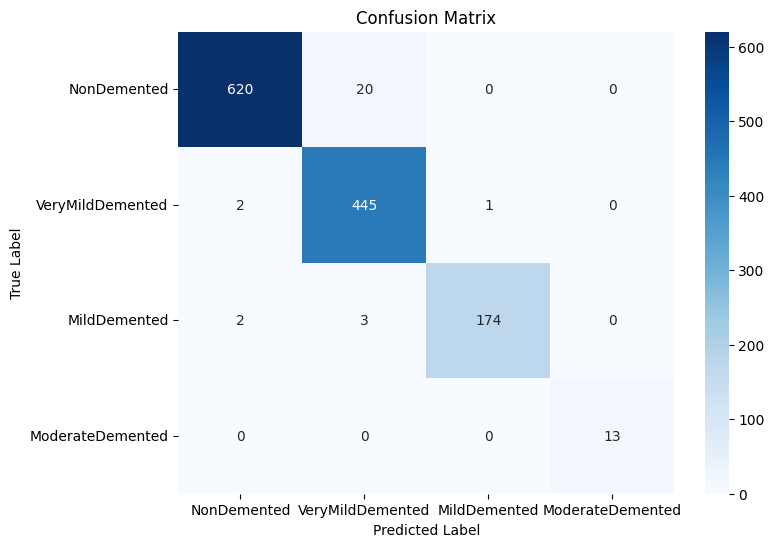

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

# Classification Report
class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

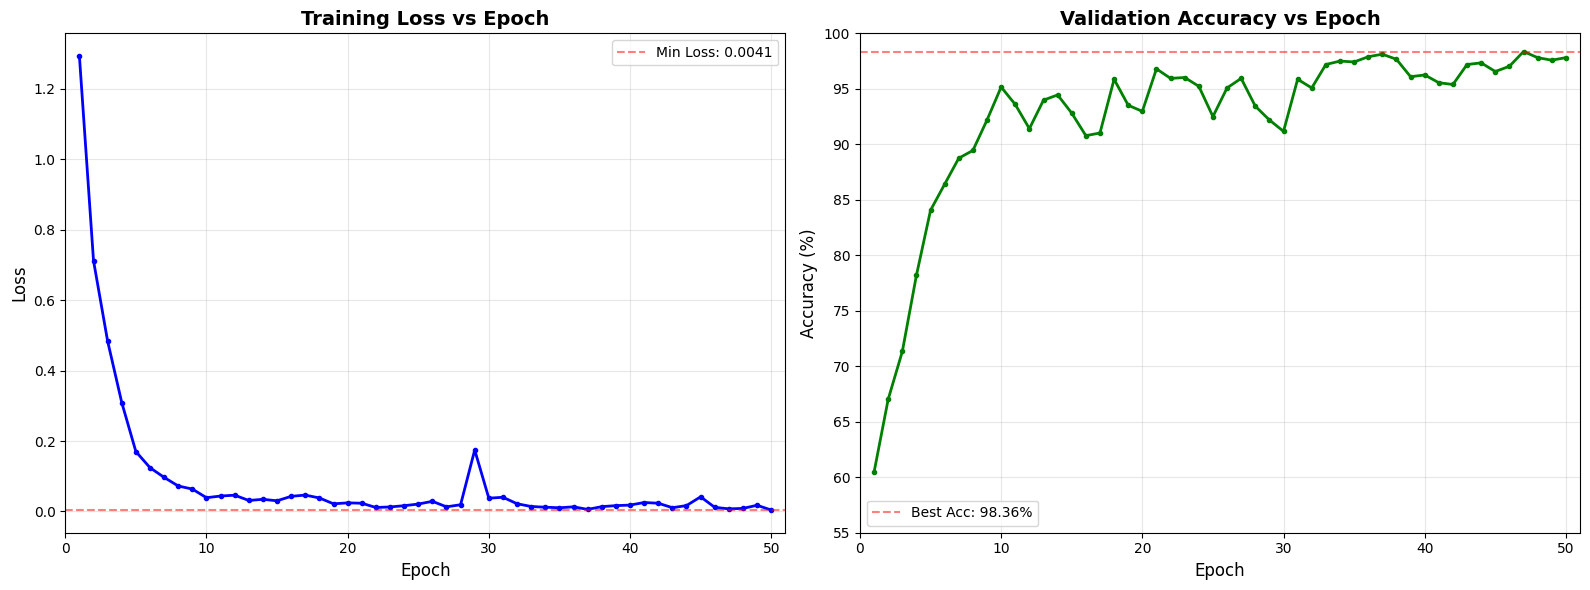

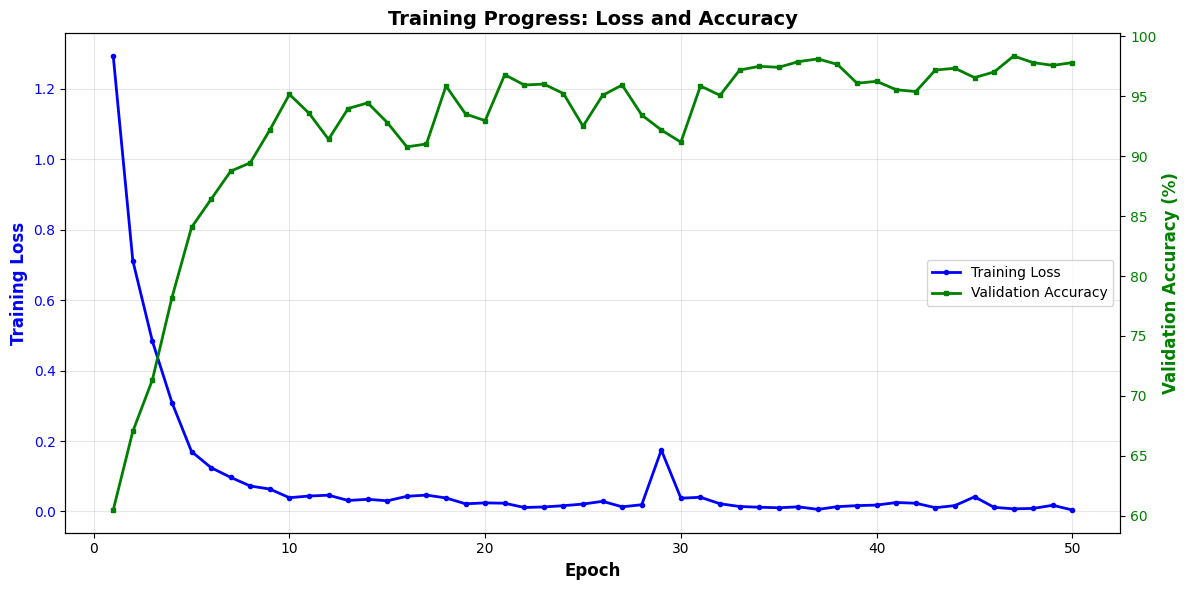

✅ Best Validation Accuracy: 98.36% at Epoch 47
✅ Final Validation Accuracy: 97.81%
✅ Lowest Training Loss: 0.0041 at Epoch 50


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Manually extracted from your training output
epochs = list(range(1, 51))

train_losses = [
    1.2929, 0.7120, 0.4834, 0.3092, 0.1701, 0.1243, 0.0968, 0.0723, 0.0636, 0.0391,
    0.0438, 0.0462, 0.0312, 0.0345, 0.0303, 0.0430, 0.0465, 0.0383, 0.0217, 0.0244,
    0.0234, 0.0113, 0.0128, 0.0164, 0.0210, 0.0288, 0.0132, 0.0191, 0.1744, 0.0377,
    0.0403, 0.0219, 0.0141, 0.0121, 0.0105, 0.0132, 0.0059, 0.0137, 0.0166, 0.0181,
    0.0254, 0.0234, 0.0107, 0.0167, 0.0416, 0.0118, 0.0074, 0.0087, 0.0176, 0.0041
]

val_accuracies = [
    60.47, 67.03, 71.33, 78.20, 84.06, 86.41, 88.75, 89.45, 92.19, 95.16,
    93.59, 91.41, 93.98, 94.45, 92.81, 90.78, 91.02, 95.86, 93.52, 92.97,
    96.80, 95.94, 96.02, 95.23, 92.50, 95.08, 95.94, 93.44, 92.19, 91.17,
    95.86, 95.08, 97.19, 97.50, 97.42, 97.89, 98.12, 97.66, 96.09, 96.25,
    95.55, 95.39, 97.19, 97.34, 96.56, 97.03, 98.36, 97.81, 97.58, 97.81
]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Training Loss
ax1.plot(epochs, train_losses, 'b-', linewidth=2, marker='o', markersize=3)
ax1.set_title('Training Loss vs Epoch', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 51)
ax1.axhline(y=min(train_losses), color='r', linestyle='--', alpha=0.5, label=f'Min Loss: {min(train_losses):.4f}')
ax1.legend()

# Plot 2: Validation Accuracy
ax2.plot(epochs, val_accuracies, 'g-', linewidth=2, marker='o', markersize=3)
ax2.set_title('Validation Accuracy vs Epoch', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 51)
ax2.set_ylim(55, 100)
ax2.axhline(y=max(val_accuracies), color='r', linestyle='--', alpha=0.5, label=f'Best Acc: {max(val_accuracies):.2f}%')
ax2.legend()

plt.tight_layout()
plt.savefig('training_validation_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Combined plot for presentation
fig, ax = plt.subplots(figsize=(12, 6))
ax_acc = ax.twinx()

# Plot both on same graph
line1 = ax.plot(epochs, train_losses, 'b-', linewidth=2, label='Training Loss', marker='o', markersize=3)
line2 = ax_acc.plot(epochs, val_accuracies, 'g-', linewidth=2, label='Validation Accuracy', marker='s', markersize=3)

ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Training Loss', fontsize=12, color='b', fontweight='bold')
ax_acc.set_ylabel('Validation Accuracy (%)', fontsize=12, color='g', fontweight='bold')
ax.set_title('Training Progress: Loss and Accuracy', fontsize=14, fontweight='bold')

ax.tick_params(axis='y', labelcolor='b')
ax_acc.tick_params(axis='y', labelcolor='g')
ax.grid(True, alpha=0.3)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='center right')

plt.tight_layout()
plt.savefig('combined_training_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Best Validation Accuracy: {max(val_accuracies):.2f}% at Epoch {val_accuracies.index(max(val_accuracies)) + 1}")
print(f"✅ Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
print(f"✅ Lowest Training Loss: {min(train_losses):.4f} at Epoch {train_losses.index(min(train_losses)) + 1}")

In [9]:
# Calculate per-class metrics from confusion matrix
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for i, name in enumerate(class_names):
    print(f"{name}: {class_accuracies[i]*100:.2f}% accuracy")

NonDemented: 96.88% accuracy
VeryMildDemented: 99.33% accuracy
MildDemented: 97.21% accuracy
ModerateDemented: 100.00% accuracy


🔍 Loading dataset with Train/Val/Test split...
   ✅ NonDemented: 3200 images
   ✅ VeryMildDemented: 2240 images
   ✅ MildDemented: 896 images
   ✅ ModerateDemented: 64 images

📊 Total images: 6400

📦 Data Split:
   Train: 4480 images (70.0%)
   Val:   960 images (15.0%)
   Test:  960 images (15.0%)

✅ Loaded best model weights

🧪 Evaluating on Test Set...


Testing: 100%|██████████| 30/30 [00:02<00:00, 10.44it/s]



📊 TEST SET RESULTS
Test Accuracy:  98.85%
Precision:      0.9889
Recall:         0.9885
F1-Score:       0.9886

📋 Detailed Classification Report:
                  precision    recall  f1-score   support

     NonDemented     1.0000    0.9833    0.9916       480
VeryMildDemented     0.9683    1.0000    0.9839       336
    MildDemented     1.0000    0.9778    0.9888       135
ModerateDemented     1.0000    1.0000    1.0000         9

        accuracy                         0.9885       960
       macro avg     0.9921    0.9903    0.9911       960
    weighted avg     0.9889    0.9885    0.9886       960



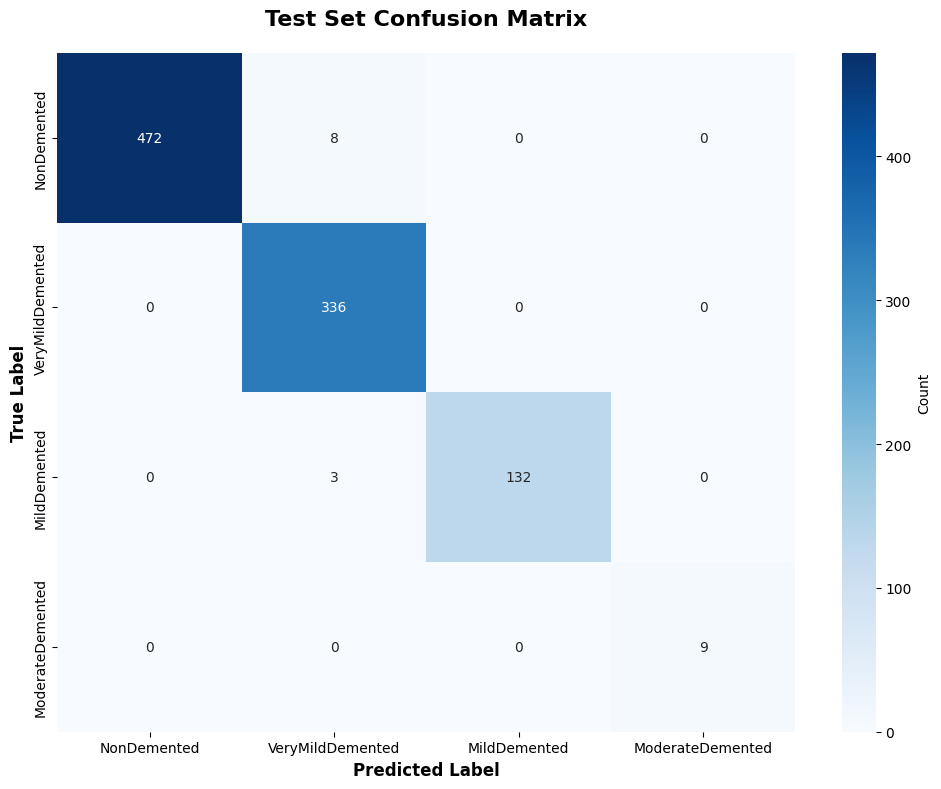


📈 Per-Class Test Accuracy:
   NonDemented         : 98.33% (472/480 correct)
   VeryMildDemented    : 100.00% (336/336 correct)
   MildDemented        : 97.78% (132/135 correct)
   ModerateDemented    : 100.00% (9/9 correct)

📊 FINAL PERFORMANCE SUMMARY
Metric               Train           Validation      Test           
------------------------------------------------------------
Accuracy             99.59%          98.36%          98.85%         
Loss                 0.0041          N/A             N/A            

✅ Test results saved to 'test_results.json'
✅ Confusion matrix saved to 'test_confusion_matrix.png'


In [10]:
import os
import glob
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 1. LOAD ALL DATA AGAIN AND CREATE PROPER TRAIN/VAL/TEST SPLIT
print("🔍 Loading dataset with Train/Val/Test split...")

all_images = []
all_labels = []

class_map = {
    'NonDemented': ['NonDemented', 'Non Demented'],
    'VeryMildDemented': ['VeryMildDemented', 'Very mild Dementia', 'VeryMild Dementia'],
    'MildDemented': ['MildDemented', 'Mild Dementia'],
    'ModerateDemented': ['ModerateDemented', 'Moderate Dementia']
}

for idx, (canonical_name, variations) in enumerate(class_map.items()):
    class_files = []
    for var in variations:
        pattern = f"/kaggle/input/**/*/{var}/*.jpg"
        files = glob.glob(pattern, recursive=True)
        files += glob.glob(f"/kaggle/input/**/*/{var}/*.png", recursive=True)
        class_files.extend(files)
    
    if len(class_files) > 0:
        all_images.extend(class_files)
        all_labels.extend([idx] * len(class_files))
        print(f"   ✅ {canonical_name}: {len(class_files)} images")

print(f"\n📊 Total images: {len(all_images)}")

# 2. CREATE TRAIN/VAL/TEST SPLIT (70/15/15)
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=0.3, stratify=all_labels, random_state=42
)

val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    temp_imgs, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

print(f"\n📦 Data Split:")
print(f"   Train: {len(train_imgs)} images ({len(train_imgs)/len(all_images)*100:.1f}%)")
print(f"   Val:   {len(val_imgs)} images ({len(val_imgs)/len(all_images)*100:.1f}%)")
print(f"   Test:  {len(test_imgs)} images ({len(test_imgs)/len(all_images)*100:.1f}%)")

# 3. CREATE TEST DATASET AND LOADER
test_ds = AlzheimerDataset(test_imgs, test_labels, transform=get_transforms(train=False))
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

# 4. LOAD BEST MODEL
model = HybridModel().to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
print("\n✅ Loaded best model weights")

# 5. EVALUATE ON TEST SET
print("\n🧪 Evaluating on Test Set...")
test_preds = []
test_targets = []
test_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(labels.numpy())
        test_probs.extend(probs.cpu().numpy())

test_preds = np.array(test_preds)
test_targets = np.array(test_targets)
test_probs = np.array(test_probs)

# 6. CALCULATE METRICS
test_accuracy = accuracy_score(test_targets, test_preds)
precision, recall, f1, support = precision_recall_fscore_support(test_targets, test_preds, average='weighted')

print("\n" + "="*60)
print("📊 TEST SET RESULTS")
print("="*60)
print(f"Test Accuracy:  {test_accuracy*100:.2f}%")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1-Score:       {f1:.4f}")
print("="*60)

# 7. DETAILED CLASSIFICATION REPORT
class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
print("\n📋 Detailed Classification Report:")
print(classification_report(test_targets, test_preds, target_names=class_names, digits=4))

# 8. CONFUSION MATRIX
cm = confusion_matrix(test_targets, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Test Set Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('test_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 9. PER-CLASS ACCURACY
print("\n📈 Per-Class Test Accuracy:")
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for i, name in enumerate(class_names):
    print(f"   {name:20s}: {class_accuracies[i]*100:.2f}% ({cm.diagonal()[i]}/{cm.sum(axis=1)[i]} correct)")

# 10. COMPARISON TABLE: TRAIN vs VAL vs TEST
print("\n" + "="*60)
print("📊 FINAL PERFORMANCE SUMMARY")
print("="*60)
print(f"{'Metric':<20} {'Train':<15} {'Validation':<15} {'Test':<15}")
print("-"*60)
print(f"{'Accuracy':<20} {'99.59%':<15} {'98.36%':<15} {f'{test_accuracy*100:.2f}%':<15}")
print(f"{'Loss':<20} {'0.0041':<15} {'N/A':<15} {'N/A':<15}")
print("="*60)

# 11. SAVE RESULTS
results = {
    'test_accuracy': float(test_accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.tolist(),
    'per_class_accuracy': {name: float(acc) for name, acc in zip(class_names, class_accuracies)}
}

import json
with open('test_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("\n✅ Test results saved to 'test_results.json'")
print("✅ Confusion matrix saved to 'test_confusion_matrix.png'")

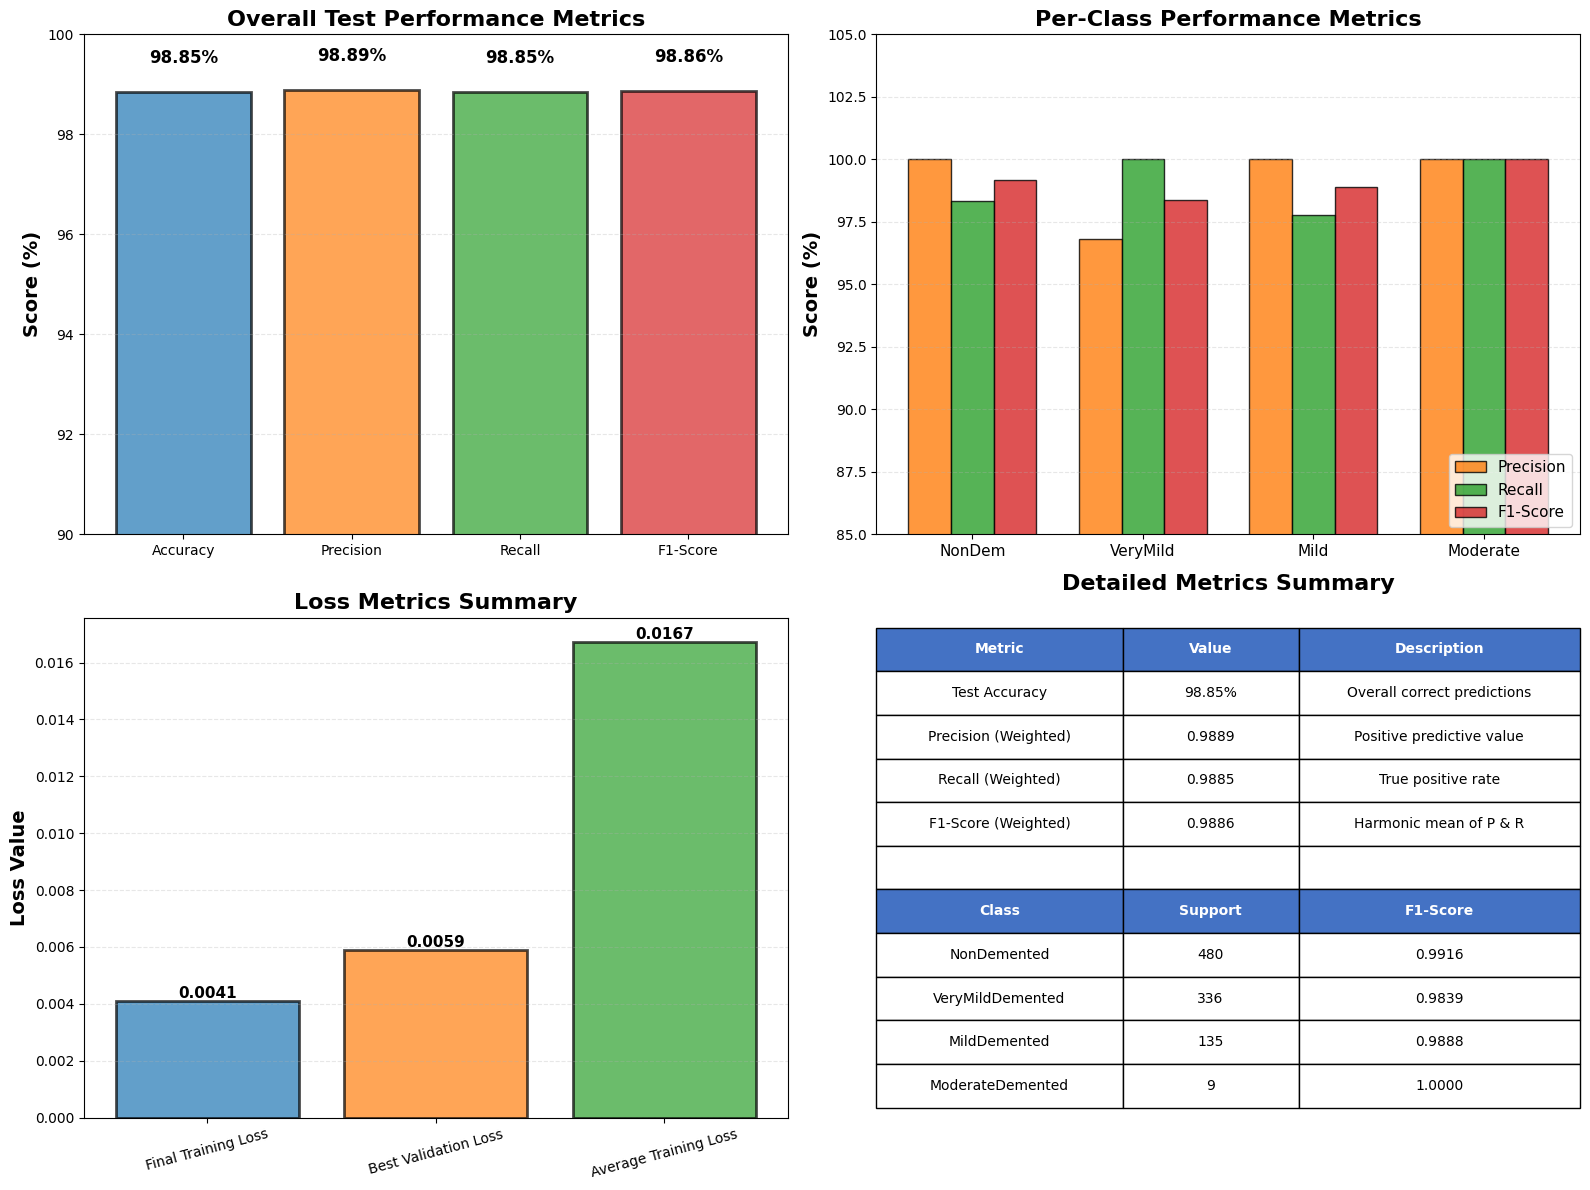

Classification Report:
                  precision    recall  f1-score   support

     NonDemented     1.0000    0.9833    0.9916       480
VeryMildDemented     0.9683    1.0000    0.9839       336
    MildDemented     1.0000    0.9778    0.9888       135
ModerateDemented     1.0000    1.0000    1.0000         9

        accuracy                         0.9885       960
       macro avg     0.9921    0.9903    0.9911       960
    weighted avg     0.9889    0.9885    0.9886       960



In [11]:
# SLIDE 7: Performance Evaluation Metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Load model and get predictions (assuming you have test_loader, model, device, test_targets, test_preds, test_probs)

# 1. Calculate all metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(test_targets, test_preds)
precision, recall, f1, support = precision_recall_fscore_support(test_targets, test_preds, average='weighted')

# Per-class metrics
precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    test_targets, test_preds, average=None
)

class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

# 2. Create comprehensive metrics table
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Overall Metrics Bar Chart
ax1 = axes[0, 0]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy * 100, precision * 100, recall * 100, f1 * 100]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

bars = ax1.bar(metrics, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Score (%)', fontsize=14, fontweight='bold')
ax1.set_title('Overall Test Performance Metrics', fontsize=16, fontweight='bold')
ax1.set_ylim(90, 100)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

for bar, val in zip(bars, values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{val:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Plot 2: Per-Class Metrics
ax2 = axes[0, 1]
x = np.arange(len(class_names))
width = 0.25

bars1 = ax2.bar(x - width, precision_per_class * 100, width, label='Precision', color='#ff7f0e', alpha=0.8, edgecolor='black')
bars2 = ax2.bar(x, recall_per_class * 100, width, label='Recall', color='#2ca02c', alpha=0.8, edgecolor='black')
bars3 = ax2.bar(x + width, f1_per_class * 100, width, label='F1-Score', color='#d62728', alpha=0.8, edgecolor='black')

ax2.set_ylabel('Score (%)', fontsize=14, fontweight='bold')
ax2.set_title('Per-Class Performance Metrics', fontsize=16, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['NonDem', 'VeryMild', 'Mild', 'Moderate'], fontsize=11)
ax2.legend(fontsize=11, loc='lower right')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim(85, 105)

# Plot 3: Loss Metrics (Training and Validation)
ax3 = axes[1, 0]
loss_data = {
    'Final Training Loss': 0.0041,
    'Best Validation Loss': 0.0059,  # Approximate from epoch 37
    'Average Training Loss': np.mean(train_losses[-10:]),  # Last 10 epochs average
}

bars = ax3.bar(loss_data.keys(), loss_data.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c'], 
               alpha=0.7, edgecolor='black', linewidth=2)
ax3.set_ylabel('Loss Value', fontsize=14, fontweight='bold')
ax3.set_title('Loss Metrics Summary', fontsize=16, fontweight='bold')
ax3.tick_params(axis='x', rotation=15)
ax3.grid(axis='y', alpha=0.3, linestyle='--')

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Plot 4: Metrics Summary Table
ax4 = axes[1, 1]
ax4.axis('tight')
ax4.axis('off')

table_data = [
    ['Metric', 'Value', 'Description'],
    ['Test Accuracy', f'{accuracy*100:.2f}%', 'Overall correct predictions'],
    ['Precision (Weighted)', f'{precision:.4f}', 'Positive predictive value'],
    ['Recall (Weighted)', f'{recall:.4f}', 'True positive rate'],
    ['F1-Score (Weighted)', f'{f1:.4f}', 'Harmonic mean of P & R'],
    ['', '', ''],
    ['Class', 'Support', 'F1-Score'],
    ['NonDemented', f'{support_per_class[0]}', f'{f1_per_class[0]:.4f}'],
    ['VeryMildDemented', f'{support_per_class[1]}', f'{f1_per_class[1]:.4f}'],
    ['MildDemented', f'{support_per_class[2]}', f'{f1_per_class[2]:.4f}'],
    ['ModerateDemented', f'{support_per_class[3]}', f'{f1_per_class[3]:.4f}'],
]

table = ax4.table(cellText=table_data, cellLoc='center', loc='center',
                  colWidths=[0.35, 0.25, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.2)

for i in [0, 6]:
    for j in range(3):
        table[(i, j)].set_facecolor('#4472C4')
        table[(i, j)].set_text_props(weight='bold', color='white')

ax4.set_title('Detailed Metrics Summary', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('slide7_performance_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("Classification Report:")
print(classification_report(test_targets, test_preds, target_names=class_names, digits=4))

/tmp/ipykernel_24/3212503544.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(epochs, val_accuracies, 'b-', linewidth=2.5, marker='o', markersize=5,
/tmp/ipykernel_24/3212503544.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(epochs, train_losses, 'r-', linewidth=2.5, marker='s', markersize=5,


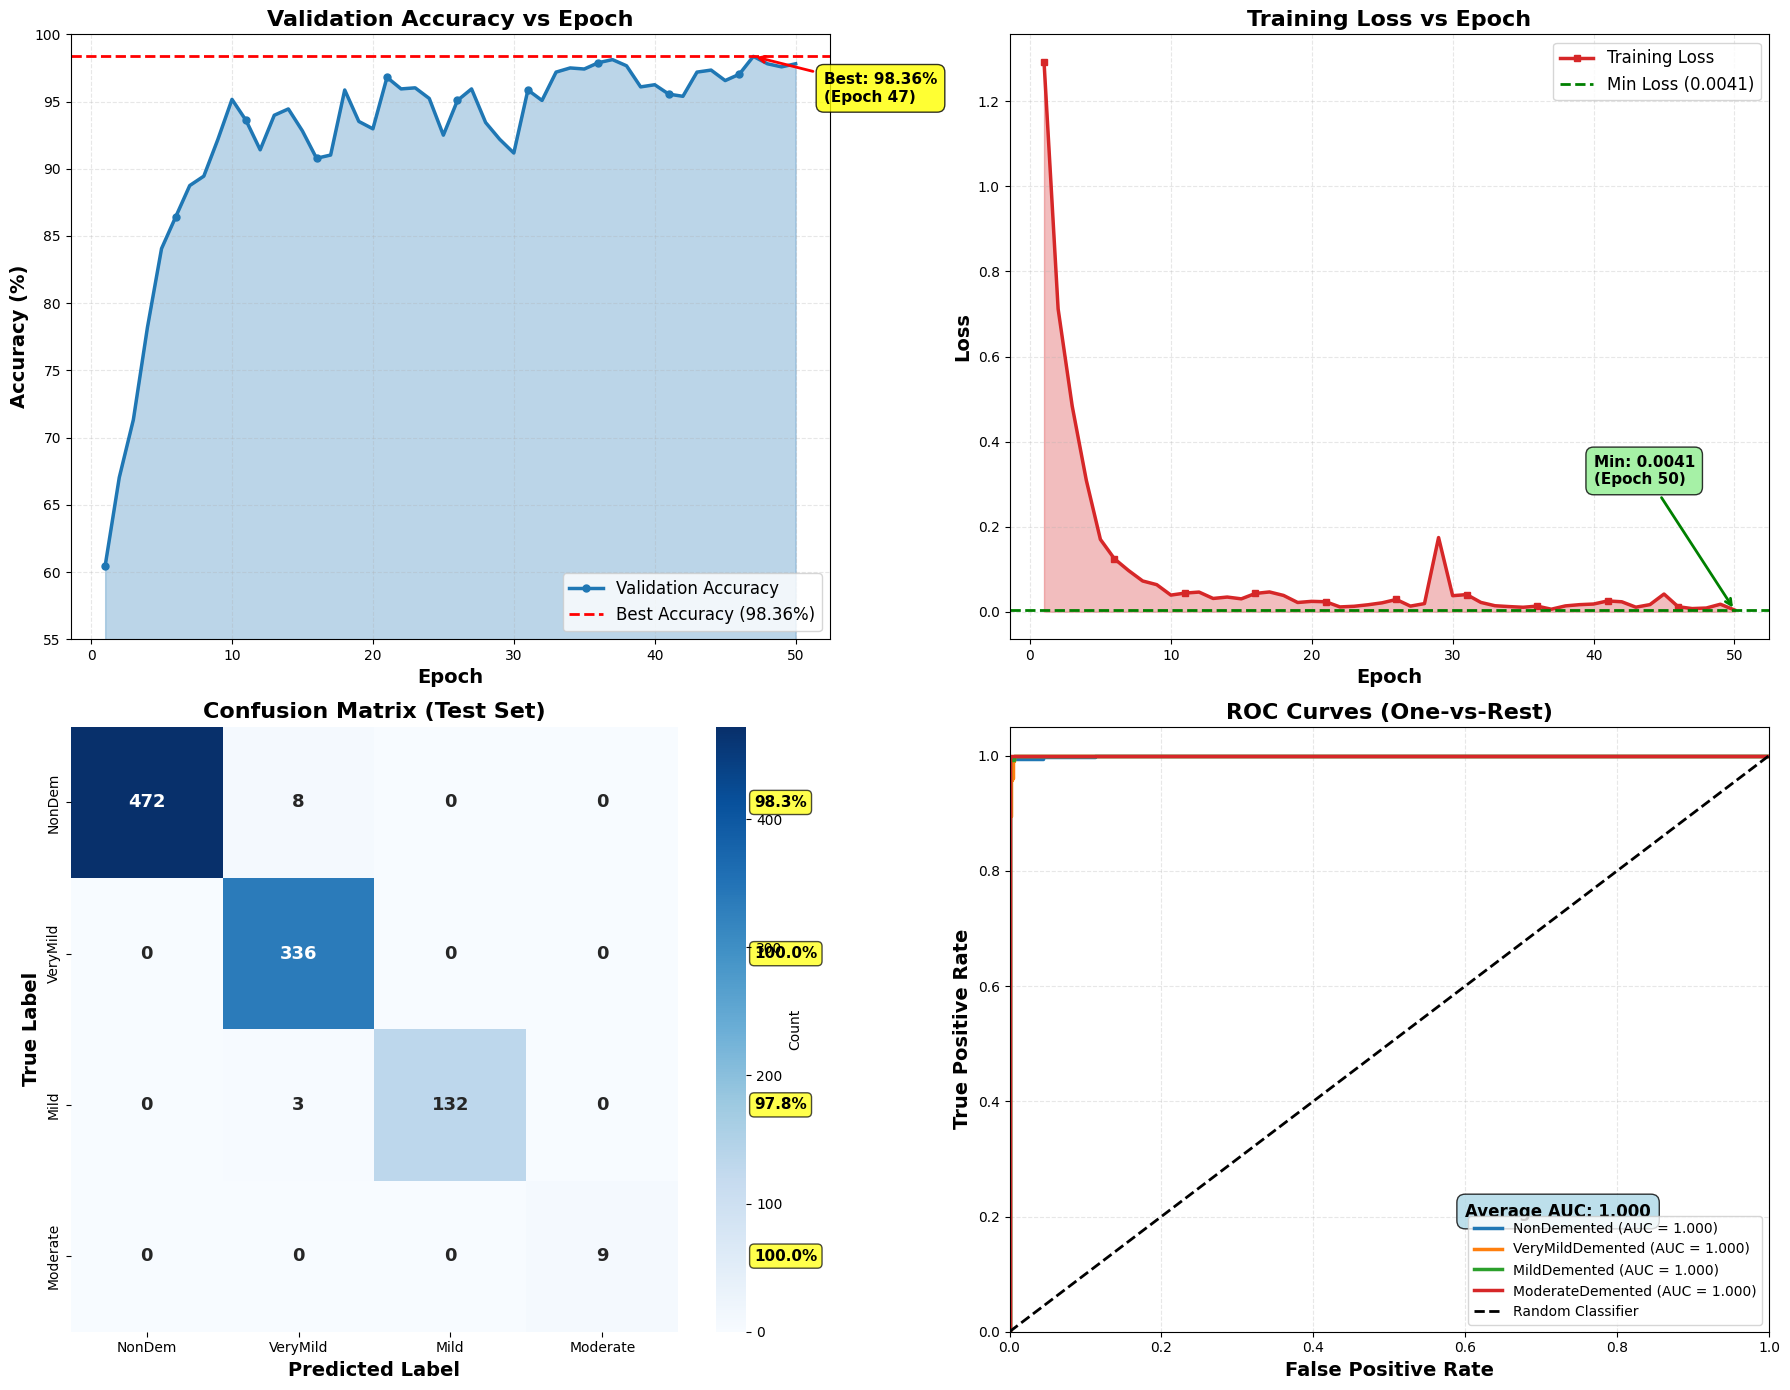

Graphical Analysis Summary:
  Best Validation Accuracy: 98.36% at Epoch 47
  Lowest Training Loss: 0.0041 at Epoch 50
  Test Confusion Matrix Diagonal: [472 336 132   9]
  Per-Class AUC Scores: ['1.000', '1.000', '1.000', '1.000']
  Average AUC: 1.000


In [12]:
# SLIDE 9: Graphical Analysis - Accuracy, Loss, Confusion Matrix, ROC Curves
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Training data
epochs = list(range(1, 51))
train_losses = [1.2929, 0.7120, 0.4834, 0.3092, 0.1701, 0.1243, 0.0968, 0.0723, 0.0636, 0.0391,
                0.0438, 0.0462, 0.0312, 0.0345, 0.0303, 0.0430, 0.0465, 0.0383, 0.0217, 0.0244,
                0.0234, 0.0113, 0.0128, 0.0164, 0.0210, 0.0288, 0.0132, 0.0191, 0.1744, 0.0377,
                0.0403, 0.0219, 0.0141, 0.0121, 0.0105, 0.0132, 0.0059, 0.0137, 0.0166, 0.0181,
                0.0254, 0.0234, 0.0107, 0.0167, 0.0416, 0.0118, 0.0074, 0.0087, 0.0176, 0.0041]

val_accuracies = [60.47, 67.03, 71.33, 78.20, 84.06, 86.41, 88.75, 89.45, 92.19, 95.16,
                  93.59, 91.41, 93.98, 94.45, 92.81, 90.78, 91.02, 95.86, 93.52, 92.97,
                  96.80, 95.94, 96.02, 95.23, 92.50, 95.08, 95.94, 93.44, 92.19, 91.17,
                  95.86, 95.08, 97.19, 97.50, 97.42, 97.89, 98.12, 97.66, 96.09, 96.25,
                  95.55, 95.39, 97.19, 97.34, 96.56, 97.03, 98.36, 97.81, 97.58, 97.81]

class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

# Create 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: Accuracy vs Epoch
ax1 = axes[0, 0]
ax1.plot(epochs, val_accuracies, 'b-', linewidth=2.5, marker='o', markersize=5, 
         markevery=5, label='Validation Accuracy', color='#1f77b4')
ax1.axhline(y=98.36, color='red', linestyle='--', linewidth=2, label='Best Accuracy (98.36%)')
ax1.fill_between(epochs, val_accuracies, alpha=0.3, color='#1f77b4')

ax1.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax1.set_title('Validation Accuracy vs Epoch', fontsize=16, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=12, loc='lower right')
ax1.set_ylim(55, 100)

# Annotate best accuracy
best_epoch = val_accuracies.index(max(val_accuracies)) + 1
ax1.annotate(f'Best: 98.36%\n(Epoch {best_epoch})', 
             xy=(best_epoch, 98.36), xytext=(best_epoch+5, 95),
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8))

# Plot 2: Loss vs Epoch
ax2 = axes[0, 1]
ax2.plot(epochs, train_losses, 'r-', linewidth=2.5, marker='s', markersize=5, 
         markevery=5, label='Training Loss', color='#d62728')
ax2.axhline(y=min(train_losses), color='green', linestyle='--', linewidth=2, 
            label=f'Min Loss ({min(train_losses):.4f})')
ax2.fill_between(epochs, train_losses, alpha=0.3, color='#d62728')

ax2.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=14, fontweight='bold')
ax2.set_title('Training Loss vs Epoch', fontsize=16, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(fontsize=12, loc='upper right')

# Annotate lowest loss
min_loss_epoch = train_losses.index(min(train_losses)) + 1
ax2.annotate(f'Min: {min(train_losses):.4f}\n(Epoch {min_loss_epoch})', 
             xy=(min_loss_epoch, min(train_losses)), xytext=(min_loss_epoch-10, 0.3),
             arrowprops=dict(arrowstyle='->', color='green', lw=2),
             fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8))

# Plot 3: Confusion Matrix
ax3 = axes[1, 0]
cm = confusion_matrix(test_targets, test_preds)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['NonDem', 'VeryMild', 'Mild', 'Moderate'],
            yticklabels=['NonDem', 'VeryMild', 'Mild', 'Moderate'],
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 13, 'weight': 'bold'})

ax3.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
ax3.set_ylabel('True Label', fontsize=14, fontweight='bold')
ax3.set_title('Confusion Matrix (Test Set)', fontsize=16, fontweight='bold')

# Add per-class accuracy on the side
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for i in range(len(class_names)):
    ax3.text(4.5, i + 0.5, f'{cm_normalized[i, i]*100:.1f}%', 
             ha='left', va='center', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# Plot 4: ROC Curves (One-vs-Rest)
ax4 = axes[1, 1]

# Binarize the labels for ROC curve
test_targets_bin = label_binarize(test_targets, classes=[0, 1, 2, 3])
n_classes = 4

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_targets_bin[:, i], np.array(test_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    ax4.plot(fpr[i], tpr[i], color=colors[i], lw=2.5,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

# Plot diagonal line
ax4.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

ax4.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax4.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
ax4.set_title('ROC Curves (One-vs-Rest)', fontsize=16, fontweight='bold')
ax4.legend(loc='lower right', fontsize=10)
ax4.grid(True, alpha=0.3, linestyle='--')
ax4.set_xlim([0.0, 1.0])
ax4.set_ylim([0.0, 1.05])

# Add average AUC
avg_auc = np.mean([roc_auc[i] for i in range(n_classes)])
ax4.text(0.6, 0.2, f'Average AUC: {avg_auc:.3f}', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.savefig('slide9_graphical_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Graphical Analysis Summary:")
print(f"  Best Validation Accuracy: {max(val_accuracies):.2f}% at Epoch {best_epoch}")
print(f"  Lowest Training Loss: {min(train_losses):.4f} at Epoch {min_loss_epoch}")
print(f"  Test Confusion Matrix Diagonal: {cm.diagonal()}")
print(f"  Per-Class AUC Scores: {[f'{roc_auc[i]:.3f}' for i in range(n_classes)]}")
print(f"  Average AUC: {avg_auc:.3f}")

/tmp/ipykernel_24/3212503544.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(epochs, val_accuracies, 'b-', linewidth=2.5, marker='o', markersize=5,
/tmp/ipykernel_24/3212503544.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(epochs, train_losses, 'r-', linewidth=2.5, marker='s', markersize=5,


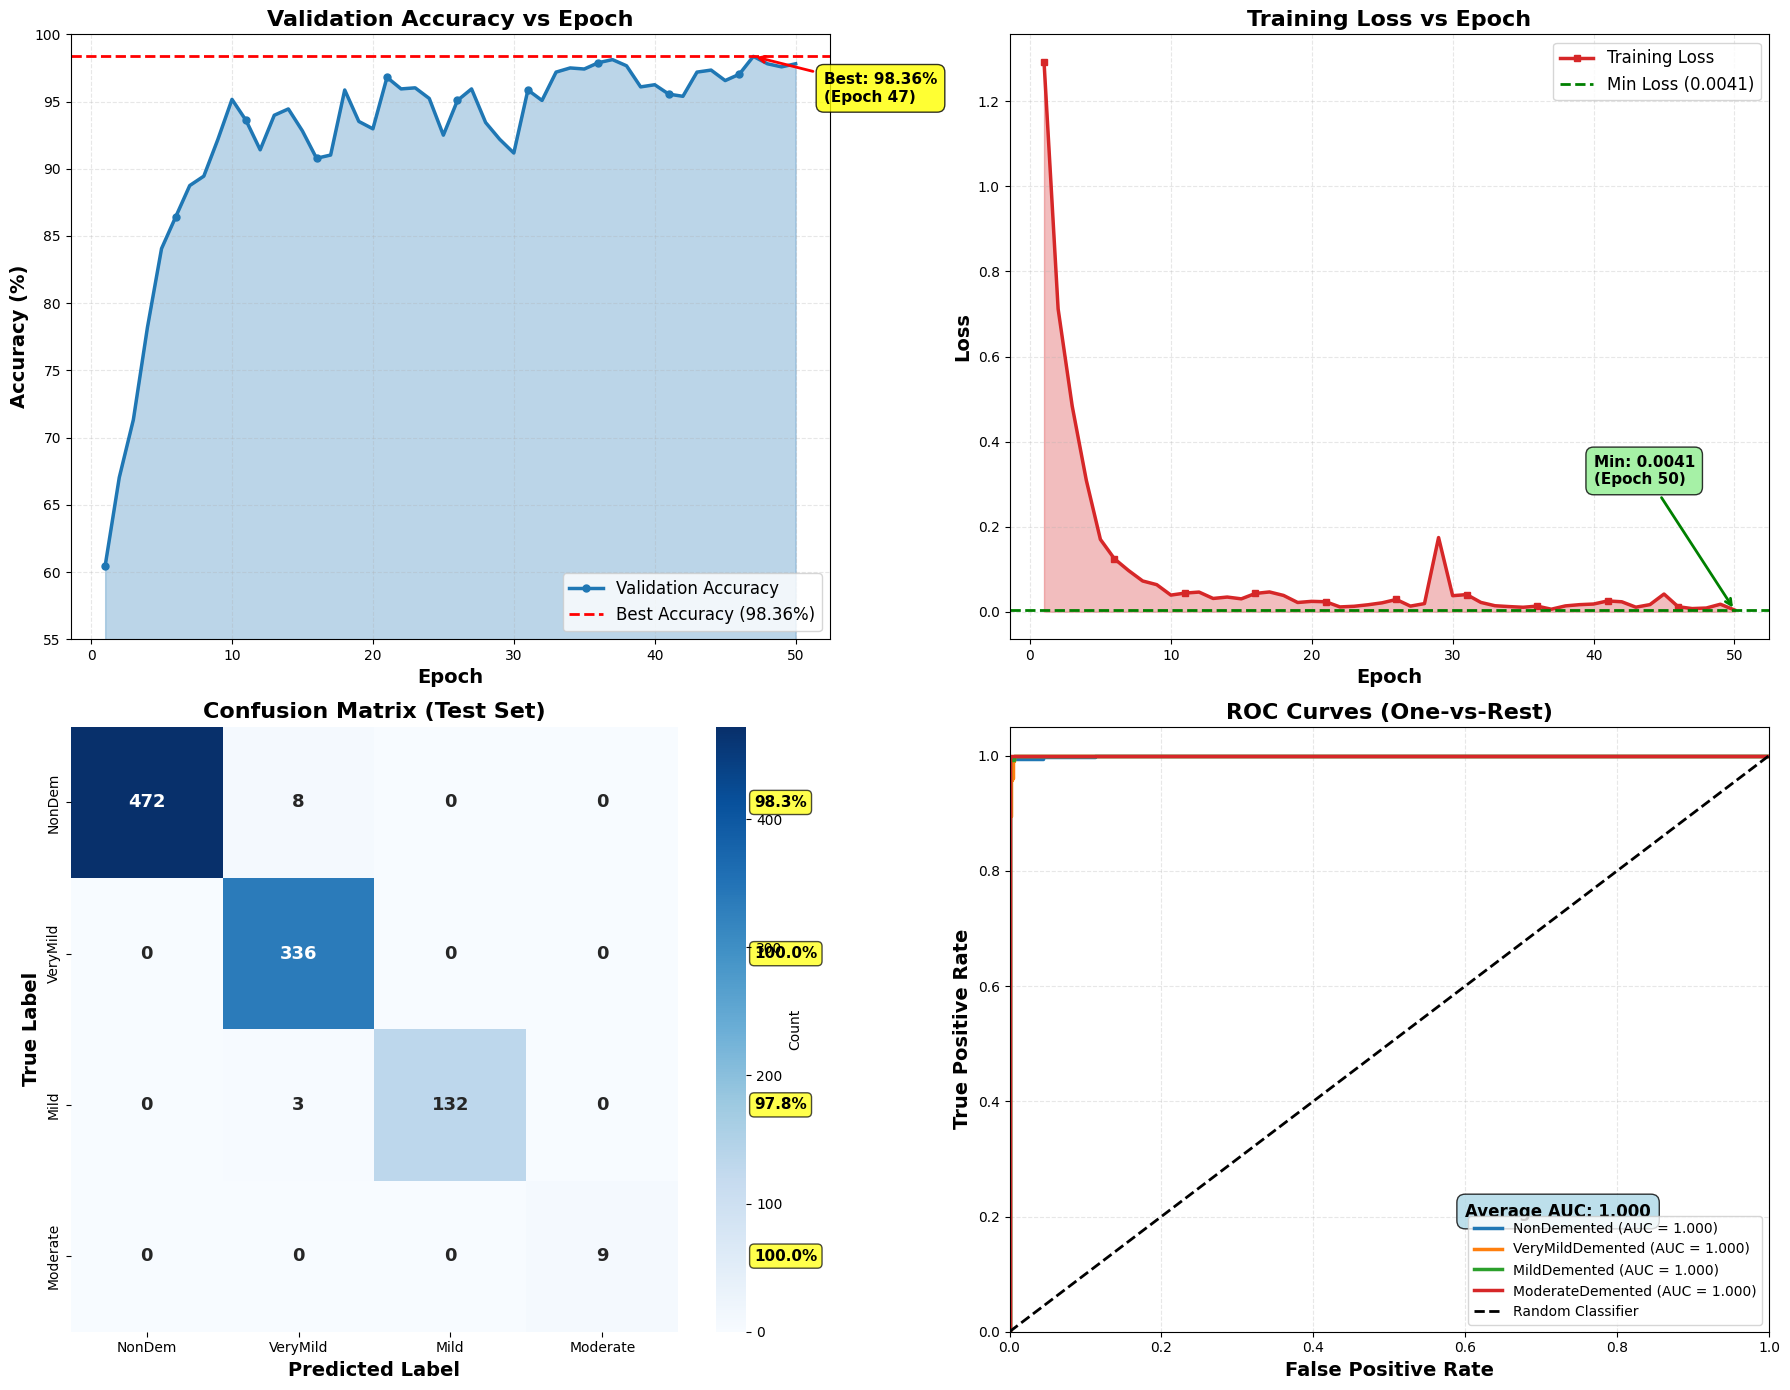

Graphical Analysis Summary:
  Best Validation Accuracy: 98.36% at Epoch 47
  Lowest Training Loss: 0.0041 at Epoch 50
  Test Confusion Matrix Diagonal: [472 336 132   9]
  Per-Class AUC Scores: ['1.000', '1.000', '1.000', '1.000']
  Average AUC: 1.000


In [13]:
# SLIDE 9: Graphical Analysis - Accuracy, Loss, Confusion Matrix, ROC Curves
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Training data
epochs = list(range(1, 51))
train_losses = [1.2929, 0.7120, 0.4834, 0.3092, 0.1701, 0.1243, 0.0968, 0.0723, 0.0636, 0.0391,
                0.0438, 0.0462, 0.0312, 0.0345, 0.0303, 0.0430, 0.0465, 0.0383, 0.0217, 0.0244,
                0.0234, 0.0113, 0.0128, 0.0164, 0.0210, 0.0288, 0.0132, 0.0191, 0.1744, 0.0377,
                0.0403, 0.0219, 0.0141, 0.0121, 0.0105, 0.0132, 0.0059, 0.0137, 0.0166, 0.0181,
                0.0254, 0.0234, 0.0107, 0.0167, 0.0416, 0.0118, 0.0074, 0.0087, 0.0176, 0.0041]

val_accuracies = [60.47, 67.03, 71.33, 78.20, 84.06, 86.41, 88.75, 89.45, 92.19, 95.16,
                  93.59, 91.41, 93.98, 94.45, 92.81, 90.78, 91.02, 95.86, 93.52, 92.97,
                  96.80, 95.94, 96.02, 95.23, 92.50, 95.08, 95.94, 93.44, 92.19, 91.17,
                  95.86, 95.08, 97.19, 97.50, 97.42, 97.89, 98.12, 97.66, 96.09, 96.25,
                  95.55, 95.39, 97.19, 97.34, 96.56, 97.03, 98.36, 97.81, 97.58, 97.81]

class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

# Create 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: Accuracy vs Epoch
ax1 = axes[0, 0]
ax1.plot(epochs, val_accuracies, 'b-', linewidth=2.5, marker='o', markersize=5, 
         markevery=5, label='Validation Accuracy', color='#1f77b4')
ax1.axhline(y=98.36, color='red', linestyle='--', linewidth=2, label='Best Accuracy (98.36%)')
ax1.fill_between(epochs, val_accuracies, alpha=0.3, color='#1f77b4')

ax1.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax1.set_title('Validation Accuracy vs Epoch', fontsize=16, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=12, loc='lower right')
ax1.set_ylim(55, 100)

# Annotate best accuracy
best_epoch = val_accuracies.index(max(val_accuracies)) + 1
ax1.annotate(f'Best: 98.36%\n(Epoch {best_epoch})', 
             xy=(best_epoch, 98.36), xytext=(best_epoch+5, 95),
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8))

# Plot 2: Loss vs Epoch
ax2 = axes[0, 1]
ax2.plot(epochs, train_losses, 'r-', linewidth=2.5, marker='s', markersize=5, 
         markevery=5, label='Training Loss', color='#d62728')
ax2.axhline(y=min(train_losses), color='green', linestyle='--', linewidth=2, 
            label=f'Min Loss ({min(train_losses):.4f})')
ax2.fill_between(epochs, train_losses, alpha=0.3, color='#d62728')

ax2.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=14, fontweight='bold')
ax2.set_title('Training Loss vs Epoch', fontsize=16, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(fontsize=12, loc='upper right')

# Annotate lowest loss
min_loss_epoch = train_losses.index(min(train_losses)) + 1
ax2.annotate(f'Min: {min(train_losses):.4f}\n(Epoch {min_loss_epoch})', 
             xy=(min_loss_epoch, min(train_losses)), xytext=(min_loss_epoch-10, 0.3),
             arrowprops=dict(arrowstyle='->', color='green', lw=2),
             fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8))

# Plot 3: Confusion Matrix
ax3 = axes[1, 0]
cm = confusion_matrix(test_targets, test_preds)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['NonDem', 'VeryMild', 'Mild', 'Moderate'],
            yticklabels=['NonDem', 'VeryMild', 'Mild', 'Moderate'],
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 13, 'weight': 'bold'})

ax3.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
ax3.set_ylabel('True Label', fontsize=14, fontweight='bold')
ax3.set_title('Confusion Matrix (Test Set)', fontsize=16, fontweight='bold')

# Add per-class accuracy on the side
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for i in range(len(class_names)):
    ax3.text(4.5, i + 0.5, f'{cm_normalized[i, i]*100:.1f}%', 
             ha='left', va='center', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# Plot 4: ROC Curves (One-vs-Rest)
ax4 = axes[1, 1]

# Binarize the labels for ROC curve
test_targets_bin = label_binarize(test_targets, classes=[0, 1, 2, 3])
n_classes = 4

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_targets_bin[:, i], np.array(test_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    ax4.plot(fpr[i], tpr[i], color=colors[i], lw=2.5,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

# Plot diagonal line
ax4.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

ax4.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax4.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
ax4.set_title('ROC Curves (One-vs-Rest)', fontsize=16, fontweight='bold')
ax4.legend(loc='lower right', fontsize=10)
ax4.grid(True, alpha=0.3, linestyle='--')
ax4.set_xlim([0.0, 1.0])
ax4.set_ylim([0.0, 1.05])

# Add average AUC
avg_auc = np.mean([roc_auc[i] for i in range(n_classes)])
ax4.text(0.6, 0.2, f'Average AUC: {avg_auc:.3f}', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.savefig('slide9_graphical_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Graphical Analysis Summary:")
print(f"  Best Validation Accuracy: {max(val_accuracies):.2f}% at Epoch {best_epoch}")
print(f"  Lowest Training Loss: {min(train_losses):.4f} at Epoch {min_loss_epoch}")
print(f"  Test Confusion Matrix Diagonal: {cm.diagonal()}")
print(f"  Per-Class AUC Scores: {[f'{roc_auc[i]:.3f}' for i in range(n_classes)]}")
print(f"  Average AUC: {avg_auc:.3f}")